In [ ]:
from zipfile import ZipFile



with ZipFile('/content/4170b385-d2e5-4e1d-a96d-cc2dfd5dd44c.zip', 'r') as zipObj:
     zipObj.extractall('images')



In [ ]:
import os
from scipy.ndimage.filters import convolve
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import ndimage
from time import time
import math

Images = []
for im in os.listdir("/content/images"):
  ima = np.array(Image.open("/content/images/" + im))
  if ima.shape[0] == 176:
    Images.append(ima)

In [ ]:
len(Images)

232

In [ ]:
x, y, c = Images[0].shape

x_len, y_len = 8, 29

ima = np.zeros((x_len*x, y_len*y, c)).astype(int)

for i in range(x_len):
  for j in range(y_len):
    ima[x*i:x*(i+1), y*j:y*(j+1)] = Images[y_len*i+j]

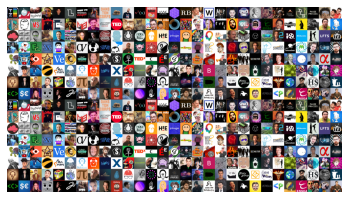

In [ ]:
plt.imshow(ima2)
plt.axis(False)
plt.savefig('Subs')

In [ ]:
ima2 = np.zeros((ima.shape[0]*2, ima.shape[1], ima.shape[2]))

ima2[:ima.shape[0]] = ima/255
ima2[ima.shape[0]:] = ima/255

print(ima2.shape)
import matplotlib

matplotlib.image.imsave('name.png', ima2)

(2816, 5104, 3)
